In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append('./')
import PhysicallyInformedLossFunctions as PhysLoss

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print (device_df.shape)
device_df.head()

(366, 11)


,Unnamed: 0,Unnamed: 0.1,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
0,0,291,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,5,0,0.053196,0.088773,2.319470,25.835041,1
1,1,283,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,5,0,0.323514,0.706579,2.021489,22.649638,7
2,2,284,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,6,0,0.620043,0.665916,1.867738,49.852415,7
3,3,280,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,2,0,0.628255,0.654254,1.915640,50.127434,7
4,4,287,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,1,0,0.637683,0.662407,2.204954,43.659713,1


In [3]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8*0.5) # 50% of x_train samples
learning_rate = 0.0005

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
X = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
Y = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [5]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Voc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Jsc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.FF_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layers
        PCE_out = self.PCE_branch(out)
        Voc_out = self.Voc_branch(out)
        Jsc_out = self.Jsc_branch(out)
        FF_out = self.FF_branch(out)
        
        return PCE_out, Voc_out, Jsc_out, FF_out

In [6]:
def train_model(model, training_data_set, optimizer):
    train_epoch_loss = []
    pce_train_epoch_loss = []
    voc_train_epoch_loss = []
    jsc_train_epoch_loss = []
    ff_train_epoch_loss = []
    
    train_losses = []
    pce_train_losses = []
    voc_train_losses = []
    jsc_train_losses = []
    ff_train_losses = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    pce_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 6)
    voc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 1)
    jsc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 10)
    ff_criterion = PhysLoss.ThresholdedMSELoss(lower = 10, upper = 85)
    
    for train_data, pce_labels, voc_labels, jsc_labels, ff_labels in training_data_set:
        
        train_data = train_data.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        PCE_out, Voc_out, Jsc_out, FF_out = model(train_data) #gather model predictions for this loop
        
        #calculate error in the predictions
        pce_loss = pce_criterion(predictions = PCE_out, labels = pce_labels)
        voc_loss = voc_criterion(Voc_out, voc_labels)
        jsc_loss = jsc_criterion(Jsc_out, jsc_labels)
        ff_loss = ff_criterion(FF_out, ff_labels)
        
        total_loss = pce_loss + voc_loss + jsc_loss + ff_loss
        
        #BACKPROPOGATE LIKE A MF
        torch.autograd.backward([pce_loss, voc_loss, jsc_loss, ff_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        pce_train_losses.append(pce_loss.item())
        voc_train_losses.append(voc_loss.item())
        jsc_train_losses.append(jsc_loss.item())
        ff_train_losses.append(ff_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    pce_train_epoch_loss.append(sum(pce_train_losses)/train_total)
    voc_train_epoch_loss.append(sum(voc_train_losses)/train_total)
    jsc_train_epoch_loss.append(sum(jsc_train_losses)/train_total)
    ff_train_epoch_loss.append(sum(ff_train_losses)/train_total)
    
    #update progress bar
    print(f"Total Epoch Training Loss = {train_epoch_loss}")
    
    return train_epoch_loss, pce_train_epoch_loss, voc_train_epoch_loss, jsc_train_epoch_loss, ff_train_epoch_loss

In [7]:
def eval_model(model, testing_data_set):
    #evaluate the model
    model.eval()
    
    pce_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 6)
    voc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 1)
    jsc_criterion = PhysLoss.ThresholdedMSELoss(lower = 0, upper = 10)
    ff_criterion = PhysLoss.ThresholdedMSELoss(lower = 10, upper = 85)
    
    accuracy = PhysLoss.MAPE()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        pce_test_losses = []
        voc_test_losses = []
        jsc_test_losses = []
        ff_test_losses = []
        
        pce_test_acc_list = []
        voc_test_acc_list = []
        jsc_test_acc_list = []
        ff_test_acc_list = []
    
        test_total = 0

        for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
            inputs = inputs.to(device)
            pce_labels = pce_labels.to(device)
            voc_labels = voc_labels.to(device)
            jsc_labels = jsc_labels.to(device)
            ff_labels = ff_labels.to(device)

            PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)

    
            # calculate loss per batch of testing data
            pce_test_loss = pce_criterion(PCE_out, pce_labels)
            voc_test_loss = voc_criterion(Voc_out, voc_labels)
            jsc_test_loss = jsc_criterion(Jsc_out, jsc_labels)
            ff_test_loss = ff_criterion(FF_out, ff_labels)
            
            test_loss = pce_test_loss + voc_test_loss + jsc_test_loss + ff_test_loss
            
            test_losses.append(test_loss.item())
            pce_test_losses.append(pce_test_loss.item())
            voc_test_losses.append(voc_test_loss.item())
            jsc_test_losses.append(jsc_test_loss.item())
            ff_test_losses.append(ff_test_loss.item())
            test_total += 1 
            
            pce_acc = accuracy(PCE_out, pce_labels)
            voc_acc = accuracy(Voc_out, voc_labels)
            jsc_acc = accuracy(Jsc_out, jsc_labels)
            ff_acc = accuracy(FF_out, ff_labels)
            
            pce_test_acc_list.append(pce_acc.item())
            voc_test_acc_list.append(voc_acc.item())
            jsc_test_acc_list.append(jsc_acc.item())
            ff_test_acc_list.append(ff_acc.item())

        test_epoch_loss = sum(test_losses)/test_total
        pce_test_epoch_loss = sum(pce_test_losses)/test_total
        voc_test_epoch_loss = sum(voc_test_losses)/test_total
        jsc_test_epoch_loss = sum(jsc_test_losses)/test_total
        ff_test_epoch_loss = sum(ff_test_losses)/test_total
        
        pce_epoch_acc = sum(pce_test_acc_list)/test_total
        voc_epoch_acc = sum(voc_test_acc_list)/test_total
        jsc_epoch_acc = sum(jsc_test_acc_list)/test_total
        ff_epoch_acc = sum(ff_test_acc_list)/test_total

        print(f"Total Epoch Testing Loss = {test_epoch_loss}")
        print(f"Epoch MAPE: PCE = {pce_epoch_acc}")
        print(f"            Voc = {voc_epoch_acc}")
        print(f"            Jsc = {jsc_epoch_acc}")
        print(f"            FF = {ff_epoch_acc}")
    return test_epoch_loss, pce_test_epoch_loss, voc_test_epoch_loss, jsc_test_epoch_loss, ff_test_epoch_loss, pce_epoch_acc, voc_epoch_acc, jsc_epoch_acc, ff_epoch_acc

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [8]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 2, out_dims = 4).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [9]:
#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

for epoch in range(num_epochs):
    
    train_epoch_loss, pce_train_epoch_loss, voc_train_epoch_loss, jsc_train_epoch_loss, ff_train_epoch_loss = train_model(model = model,
                                                                                                                          training_data_set = training_data_set,
                                                                                                                          optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    pce_train_epoch_losses.append(pce_train_epoch_loss)
    voc_train_epoch_losses.append(voc_train_epoch_loss)
    jsc_train_epoch_losses.append(jsc_train_epoch_loss)
    ff_train_epoch_losses.append(ff_train_epoch_loss)
    
    test_epoch_loss, pce_test_epoch_loss, voc_test_epoch_loss, jsc_test_epoch_loss, ff_test_epoch_loss, pce_epoch_acc, voc_epoch_acc, jsc_epoch_acc, ff_epoch_acc = eval_model(model = model,
                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_epoch_loss)
    pce_test_epoch_losses.append(pce_test_epoch_loss)
    voc_test_epoch_losses.append(voc_test_epoch_loss)
    jsc_test_epoch_losses.append(jsc_test_epoch_loss)
    ff_test_epoch_losses.append(ff_test_epoch_loss)
    
    pce_test_epoch_accuracies.append(pce_epoch_acc)
    voc_test_epoch_accuracies.append(voc_epoch_acc)
    jsc_test_epoch_accuracies.append(jsc_epoch_acc)
    ff_test_epoch_accuracies.append(ff_epoch_acc)

Total Epoch Training Loss = [27.656367301940918]
Total Epoch Testing Loss = 32.63454055786133
Epoch MAPE: PCE = 120.73233320906355
            Voc = 85.6717960254566
            Jsc = 95.61258264490075
            FF = 98.4799049996041
Total Epoch Training Loss = [17.770870208740234]
Total Epoch Testing Loss = 47.79722595214844
Epoch MAPE: PCE = 109.71305434768264
            Voc = 50.56581239442568
            Jsc = 89.07766599912901
            FF = 97.56926459235113
Total Epoch Training Loss = [12.238340377807617]
Total Epoch Testing Loss = 63.64595413208008
Epoch MAPE: PCE = 100.70815215239655
            Voc = 71.2569674930057
            Jsc = 81.66216772955816
            FF = 96.74749632139464
Total Epoch Training Loss = [14.507082462310791]
Total Epoch Testing Loss = 47.81703567504883
Epoch MAPE: PCE = 91.84736303381018
            Voc = 67.1905672228014
            Jsc = 73.6529221405854
            FF = 95.82580360206397
Total Epoch Training Loss = [19.95225954055786]
Total 

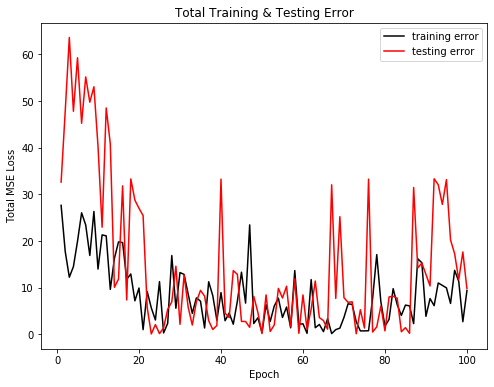

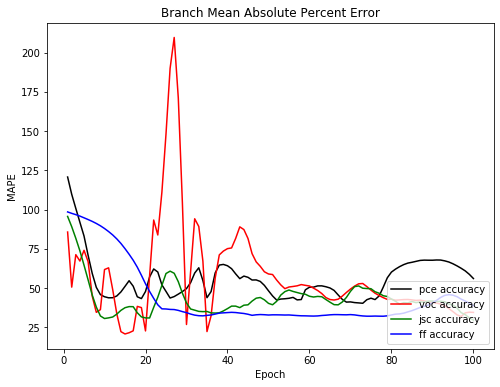

In [10]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
# plt.plot(epochs, train_epoch_accuracy, c = 'k', label = 'training accuracy')
plt.plot(epochs, pce_test_epoch_accuracies, c = 'k', label = 'pce accuracy')
plt.plot(epochs, voc_test_epoch_accuracies, c = 'r', label = 'voc accuracy')
plt.plot(epochs, jsc_test_epoch_accuracies, c = 'g', label = 'jsc accuracy')
plt.plot(epochs, ff_test_epoch_accuracies, c = 'b', label = 'ff accuracy')
plt.legend(loc = 'lower right')
plt.title("Branch Mean Absolute Percent Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('MAPE')
plt.show()

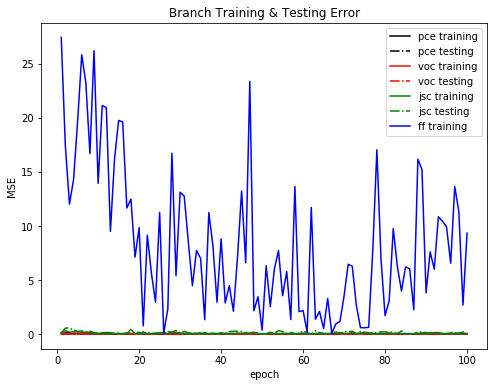

In [11]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, pce_train_epoch_losses, c = 'k', label = 'pce training')
plt.plot(epochs, pce_test_epoch_losses, '-.', c = 'k', label = 'pce testing')

plt.plot(epochs, voc_train_epoch_losses, c = 'r', label = 'voc training')
plt.plot(epochs, voc_test_epoch_losses, '-.', c = 'r', label = 'voc testing')

plt.plot(epochs, jsc_train_epoch_losses, c = 'g', label = 'jsc training')
plt.plot(epochs, jsc_test_epoch_losses, '-.', c = 'g', label = 'jsc testing') #This error is second worst

plt.plot(epochs, ff_train_epoch_losses, c = 'b', label = 'ff training') 
# plt.plot(epochs, ff_test_epoch_losses, '-.', c = 'b', label = 'ff testing') #This error is by far the worst

plt.legend(loc = 'upper right')
plt.title("Branch Training & Testing Error")
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
plt.show()

In [12]:
model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)


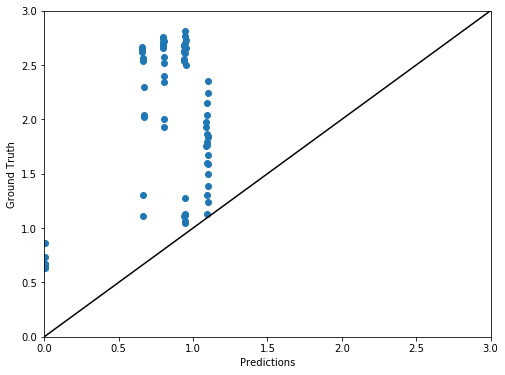

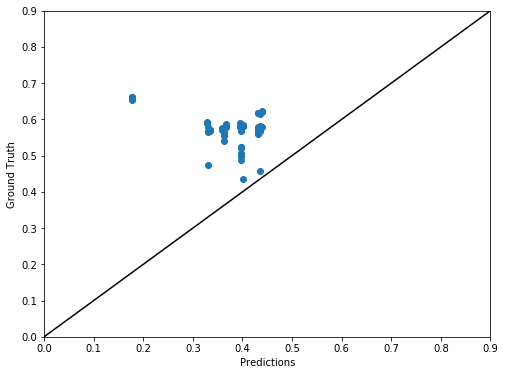

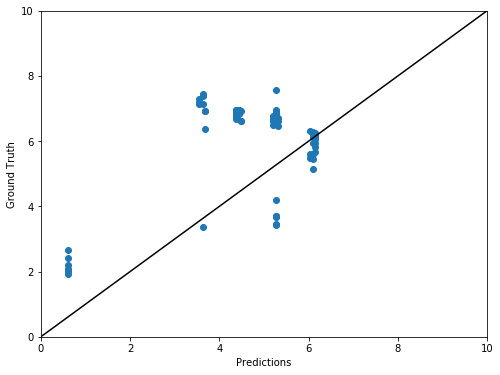

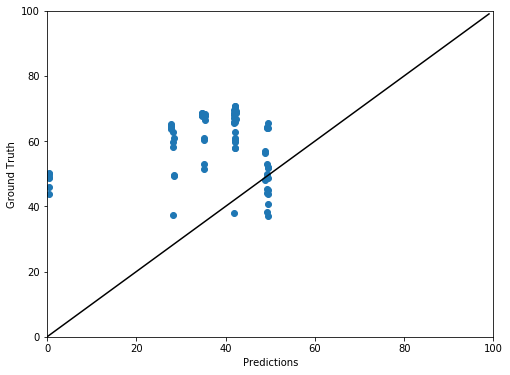

In [13]:
xlin = ylin = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize = (8,6))

plt.scatter(PCE_out, pce_labels)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.show()

fig, ax = plt.subplots(figsize = (8,6))

plt.scatter(Voc_out, voc_labels)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.show()

fig, ax = plt.subplots(figsize = (8,6))

plt.scatter(Jsc_out, jsc_labels)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.show()

fig, ax = plt.subplots(figsize = (8,6))

plt.scatter(FF_out, ff_labels)
plt.plot(xlin, ylin, c = 'k')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel("Predictions")
ax.set_ylabel("Ground Truth")
plt.show()